In [32]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

##from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [33]:
df = pd.read_pickle('/Users/markantimonov/Desktop/my_proj/data/clean_car_data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       301 non-null    category
 1   Year           301 non-null    int16   
 2   Selling_Price  301 non-null    float16 
 3   Present_Price  301 non-null    float16 
 4   Driven_kms     301 non-null    int64   
 5   Fuel_Type      301 non-null    category
 6   Selling_type   301 non-null    category
 7   Transmission   301 non-null    category
 8   Owner          301 non-null    int8    
dtypes: category(4), float16(2), int16(1), int64(1), int8(1)
memory usage: 6.5 KB


In [34]:
# clean_data — это обработанный DataFrame, который вы должны получить после очистки данных
clean_data = pd.read_pickle('/Users/markantimonov/Desktop/my_proj/data/clean_car_data.pkl')  # или результат вашей обработки

In [35]:
df = df.rename(columns={'Selling_Price': 'target'})
df = df.drop(columns=['Owner'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       301 non-null    category
 1   Year           301 non-null    int16   
 2   target         301 non-null    float16 
 3   Present_Price  301 non-null    float16 
 4   Driven_kms     301 non-null    int64   
 5   Fuel_Type      301 non-null    category
 6   Selling_type   301 non-null    category
 7   Transmission   301 non-null    category
dtypes: category(4), float16(2), int16(1), int64(1)
memory usage: 6.2 KB


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [37]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']

In [38]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['Year', 'Present_Price', 'Driven_kms']

In [39]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999) # unknown_value нужно выбирать с умом
regressor = RandomForestRegressor()

In [40]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [41]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor())])

In [42]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5070508776212993,
 'mape': 0.24853691574462855,
 'mse': 0.6498685968535903}

Работа с MLFLow

In [43]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri) 

In [44]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "Predict_price_project"
RUN_NAME = "baseline_model"
REGISTRY_MODEL_NAME = "car_model_rf"

In [45]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)
req_file = '../requirements.txt'
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline.get_params()

/Users/markantimonov/Desktop/my_proj/.venv_my_proj/lib/python3.9/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [46]:
## Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/15 02:54:36 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.17.2, required: mlflow==2.16)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/15 02:54:36 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.17.2, required: mlflow==2.16)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/15 02:54:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline_model at: http://127.0.0.1:5001/#/experiments/1/runs/6360b84617414bab94b1d8ef2ff25a85.
2024/11/15 02:54:36 INFO mlflow.tracking._tracking

ПУНКТ 10

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler

# Числовые признаки
numeric_features = ['Year', 'Present_Price', 'Driven_kms']

# Создание ColumnTransformer
transformer = ColumnTransformer(transformers=[
    # Polynomial Features для 'Present_Price' и 'Driven_kms'
    ('poly', Pipeline([
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), ['Present_Price', 'Driven_kms']),

    # KBinsDiscretizer для 'Year'
    ('k_bins', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['Year'])
])

In [48]:
X_train_fe_sklearn = X_train.copy()  # Создайте копию обучающего набора
X_train_fe_sklearn = transformer.fit_transform(X_train_fe_sklearn)

In [49]:
# Получение названий новых признаков
column_names = transformer.get_feature_names_out()

# Сохранение в файл
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(column_names))   

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Вычисление метрик
metrics = {
    'mae': mean_absolute_error(y_test, predictions),
    'mape': mean_absolute_percentage_error(y_test, predictions),
    'mse': mean_squared_error(y_test, predictions)
}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'Feature Engineering with Polynomial Features and Binning'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # Логирование модели
    mlflow.sklearn.log_model(pipeline, artifact_path="models")
    
    # Логирование метрик
    mlflow.log_metrics(metrics)
    
    # Логирование файла с именами признаков
    mlflow.log_artifact('feature_names.txt')

2024/11/15 02:54:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 02:54:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Feature Engineering with Polynomial Features and Binning at: http://127.0.0.1:5001/#/experiments/1/runs/cf3a9df98ae442e79e62fbb10bb05d5b.
2024/11/15 02:54:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.


In [52]:
display(X_train.head(10))

,Car_Name,Year,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission
155,Honda Activa 4G,2017,0.509766,4300,Petrol,Individual,Automatic
104,Royal Enfield Classic 350,2017,1.469727,4100,Petrol,Individual,Manual
285,jazz,2016,8.500000,15059,Petrol,Dealer,Automatic
219,verna,2012,9.398438,36000,Petrol,Dealer,Manual
291,brio,2015,6.101562,31427,Petrol,Dealer,Manual
84,innova,2005,13.460938,197176,Diesel,Dealer,Manual
24,wagon r,2013,4.410156,56879,Petrol,Dealer,Manual
280,brio,2015,5.898438,14465,Petrol,Dealer,Manual
113,Mahindra Mojo XT300,2016,1.400391,35000,Petrol,Individual,Manual
153,Bajaj Pulsar NS 200,2013,0.990234,45000,Petrol,Individual,Manual


In [53]:
transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=transformer.get_feature_names_out())
display(transformed_df.head(10))

,poly__Present_Price,poly__Driven_kms,poly__Present_Price^2,poly__Present_Price Driven_kms,poly__Driven_kms^2,k_bins__Year
0,-0.812908,-0.797744,-0.246557,-0.526378,-0.186065,4.0
1,-0.709025,-0.802502,-0.243423,-0.520801,-0.186163,4.0
2,0.051765,-0.541795,-0.127813,-0.343342,-0.173878,4.0
3,0.148991,-0.043623,-0.101289,-0.037321,-0.111314,3.0
4,-0.207785,-0.152412,-0.185579,-0.250590,-0.129356,4.0
5,0.588619,3.790644,0.051889,3.331914,2.087737,0.0
6,-0.390822,0.453074,-0.214905,-0.164620,0.002155,3.0
7,-0.229766,-0.555926,-0.189599,-0.405436,-0.174904,4.0
8,-0.716528,-0.067412,-0.243751,-0.458259,-0.115469,4.0
9,-0.760914,0.170481,-0.245369,-0.464738,-0.068658,3.0


In [54]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 0.5753952508223685,
 'mape': 0.17770516344686227,
 'mse': 1.1121661235173674}

ПУНКТ 12

In [55]:
from mlxtend.feature_selection import SequentialFeatureSelector 

Выбранные индексы: [0, 2, 5]
Выбранные признаки: ['0', '2', '5']


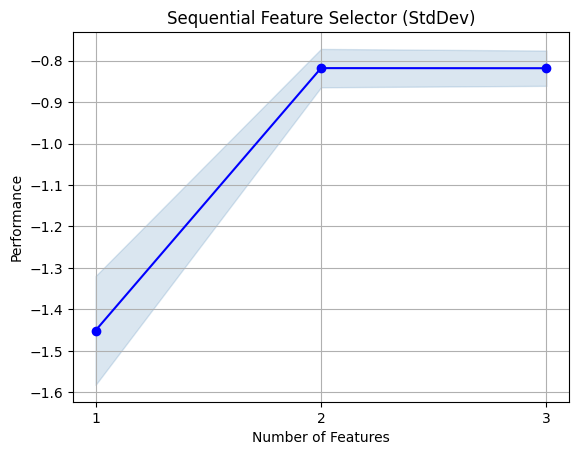

Метрики: {'mae': 0.5962188217281915, 'mape': 0.1912716630241446, 'mse': 1.129391115308876}


2024/11/15 02:54:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 02:54:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run SequentialFeatureSelection at: http://127.0.0.1:5001/#/experiments/1/runs/cf095c699f3345c188087c5e1ad270f4.
2024/11/15 02:54:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.


Эксперимент завершён, результаты залогированы.


In [56]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import mlflow
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pandas as pd

# Укажите, сколько признаков нужно отобрать
n_features = int(X_train_fe_sklearn.shape[1] * 0.5)  # Например, 50% от общего числа

# Создайте модель
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Sequential Feature Selector
sfs = SequentialFeatureSelector(
    estimator=model,
    k_features=n_features,
    forward=True,  # Последовательное добавление признаков
    floating=False,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

# Обучение SFS на данных
sfs.fit(X_train_fe_sklearn, y_train)

# Извлечение результатов
selected_indices = list(sfs.k_feature_idx_)
selected_columns = list(sfs.k_feature_names_)

print("Выбранные индексы:", selected_indices)
print("Выбранные признаки:", selected_columns)

# Сохранение результатов в файлы
with open('selected_indices.txt', 'w') as f:
    f.write('\n'.join(map(str, selected_indices)))

with open('selected_columns.txt', 'w') as f:
    f.write('\n'.join(selected_columns))

# Визуализация метрик
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Feature Selector (StdDev)')
plt.grid()
plt.show()

# Создание нового Pipeline
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', transformer),  # Шаг с трансформациями из пункта 10
    ('feature_selector', SequentialFeatureSelector(
        estimator=model,
        k_features=n_features,
        forward=True,
        floating=False,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1
    )),
    ('model', RandomForestRegressor(random_state=42))
])

# Обучение нового Pipeline
rfe_sfs_pipeline.fit(X_train, y_train)

# Предсказания
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

# Метрики
metrics = {
    "mae": mean_absolute_error(y_test, predictions_sfs),
    "mape": mean_absolute_percentage_error(y_test, predictions_sfs),
    "mse": mean_squared_error(y_test, predictions_sfs)
}

print("Метрики:", metrics)

# Логирование результатов с помощью MLflow
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = "SequentialFeatureSelection"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # Логирование модели
    mlflow.sklearn.log_model(rfe_sfs_pipeline, artifact_path="models")
    
    # Логирование метрик
    mlflow.log_metrics(metrics)
    
    # Логирование артефактов
    mlflow.log_artifact('selected_indices.txt')
    mlflow.log_artifact('selected_columns.txt')
    
    # Логирование параметров модели
    mlflow.log_params(model.get_params())

print("Эксперимент завершён, результаты залогированы.")

In [ ]:
# mlflow.delete_run('d40b881ff20d4efea4a93b9714f9802a')

ПУНКТ 14

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
import optuna
import mlflow
import mlflow.sklearn

# Определение категориальных и числовых признаков
categorical_features = ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']
numerical_features = ['Year', 'Present_Price', 'Driven_kms']

# Создание трансформера с параметром handle_unknown='ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Преобразование данных
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Разделение данных
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

# Определение функции оптимизации
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)  # Количество деревьев
    max_depth = trial.suggest_int("max_depth", 5, 30)  # Глубина дерева
    max_features = trial.suggest_float("max_features", 0.1, 1.0)  # Часть признаков

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )

    model.fit(X_train_opt, y_train_opt)
    predictions = model.predict(X_val_opt)
    mae = mean_absolute_error(y_val_opt, predictions)

    return mae  # Минимизируем MAE

# Оптимизация с Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Лучшая комбинация параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train_processed, y_train)

# Предсказания и метрики
final_predictions = best_model.predict(X_test_processed)
metrics = {
    "mae": mean_absolute_error(y_test, final_predictions),
    "mape": mean_absolute_percentage_error(y_test, final_predictions),
    "mse": mean_squared_error(y_test, final_predictions)
}
print("Метрики на тестовых данных:", metrics)

# Логирование модели в MLflow
RUN_NAME = "RandomForest Hyperparameter Optimization"
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(best_model, artifact_path="models")
    mlflow.log_metrics(metrics)
    mlflow.log_params(best_params)

# Регистрация модели
mlflow.register_model(
    "runs:/{}/models".format(run.info.run_id),
    name="RandomForestModel"
)
print("Модель зарегистрирована как новая версия.")

[I 2024-11-15 03:07:51,568] A new study created in memory with name: no-name-a1c5e519-5194-47d1-923e-3af7a998af1a
[I 2024-11-15 03:07:51,679] Trial 0 finished with value: 1.475069413206062 and parameters: {'n_estimators': 153, 'max_depth': 15, 'max_features': 0.3886235252495438}. Best is trial 0 with value: 1.475069413206062.
[I 2024-11-15 03:07:51,793] Trial 1 finished with value: 1.531642703006745 and parameters: {'n_estimators': 192, 'max_depth': 6, 'max_features': 0.5591798904014765}. Best is trial 0 with value: 1.475069413206062.
[I 2024-11-15 03:07:51,951] Trial 2 finished with value: 1.5156558890372 and parameters: {'n_estimators': 199, 'max_depth': 26, 'max_features': 0.2803634728001072}. Best is trial 0 with value: 1.475069413206062.
[I 2024-11-15 03:07:52,168] Trial 3 finished with value: 1.3309568891594943 and parameters: {'n_estimators': 285, 'max_depth': 9, 'max_features': 0.9031495564315373}. Best is trial 3 with value: 1.3309568891594943.
[I 2024-11-15 03:07:52,219] Tria

Лучшие параметры: {'n_estimators': 285, 'max_depth': 9, 'max_features': 0.9031495564315373}
Метрики на тестовых данных: {'mae': 0.49279834960635166, 'mape': 0.1596328209361644, 'mse': 0.6925768482947682}


2024/11/15 03:07:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/15 03:07:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest Hyperparameter Optimization at: http://127.0.0.1:5001/#/experiments/1/runs/5627ba29c4fd4ae18a98e2b8d085ac00.
2024/11/15 03:07:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1.
Registered model 'RandomForestModel' already exists. Creating a new version of this model...
2024/11/15 03:07:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestModel, version 3


Модель зарегистрирована как новая версия.


Created version '3' of model 'RandomForestModel'.
